In [3]:
import os
import cv2
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.applications.densenet import preprocess_input

In [18]:
data = pd.read_csv('scraped_data.csv')

In [19]:
data


,image_id,image_caption,comparison,indication,findings,impression
0,CXR1_1_IM-0001-3001.png,ray chest pa and lateral,none,positive tb test,the cardiac silhouette and mediastinum size ar...,normal chest x
1,CXR1_1_IM-0001-4001.png,ray chest pa and lateral,none,positive tb test,the cardiac silhouette and mediastinum size ar...,normal chest x
2,CXR10_IM-0002-1001.png,pa and lateral chest x,chest radiographs,male chest pain,the cardiomediastinal silhouette is within nor...,no acute cardiopulmonary process
3,CXR10_IM-0002-2001.png,pa and lateral chest x,chest radiographs,male chest pain,the cardiomediastinal silhouette is within nor...,no acute cardiopulmonary process
4,CXR100_IM-0002-1001.png,chest frontal lateral pm,none,no indication,both lungs are clear and expanded heart and me...,no active disease
...,...,...,...,...,...,...
7465,CXR998_IM-2479-1001.png,pa and lateral chest x dated at am,none,with pain,cardiomediastinal silhouette demonstrates norm...,no acute cardiopulmonary abnormality
7466,CXR998_IM-2479-2001.png,pa and lateral chest x dated at am,none,with pain,cardiomediastinal silhouette demonstrates norm...,no acute cardiopulmonary abnormality
7467,CXR999_IM-2480-1001.png,chest two views pa and lateral pm,none,chest pain,lungs are clear bilaterally there is no focal ...,no acute cardiopulmonary abnormality
7468,CXR999_IM-2480-2001.png,chest two views pa and lateral pm,none,chest pain,lungs are clear bilaterally there is no focal ...,no acute cardiopulmonary abnormality


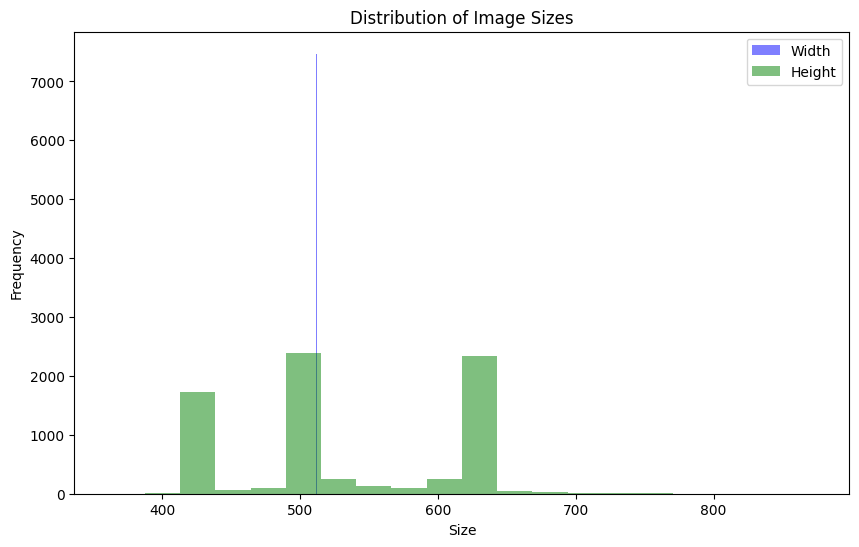

In [26]:
# Define the folder path where the images are located
folder_path = 'NLMCXR_png/'

# Get the list of image files in the folder
image_files = [file for file in os.listdir(folder_path) if file.endswith('.jpg') or file.endswith('.png')]

# Initialize lists to store the image sizes
widths = []
heights = []

# Iterate through the image files and get their sizes
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    image = cv2.imread(image_path)
    height, width, _ = image.shape
    widths.append(width)
    heights.append(height)

# Plot the distribution of image sizes
plt.figure(figsize=(10, 6))
plt.hist(widths, bins=20, alpha=0.5, color='blue', label='Width')
plt.hist(heights, bins=20, alpha=0.5, color='green', label='Height')
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.title('Distribution of Image Sizes')
plt.legend()
plt.show()


In [29]:
np.median(widths), np.median(heights) 

(512.0, 512.0)

In [30]:
# Define the folder paths
input_folder = 'NLMCXR_png'
output_folder = 'NLMCXR_png_resized'

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Get the list of image files in the input folder
image_files = [file for file in os.listdir(input_folder) if file.endswith('.jpg') or file.endswith('.png')]

# Iterate through the image files and resize them
for image_file in image_files:
    # Read the image
    image_path = os.path.join(input_folder, image_file)
    image = cv2.imread(image_path)
    
    # Resize the image to 512x512
    resized_image = cv2.resize(image, (512, 512))
    
    # Save the resized image to the output folder
    output_path = os.path.join(output_folder, image_file)
    cv2.imwrite(output_path, resized_image)


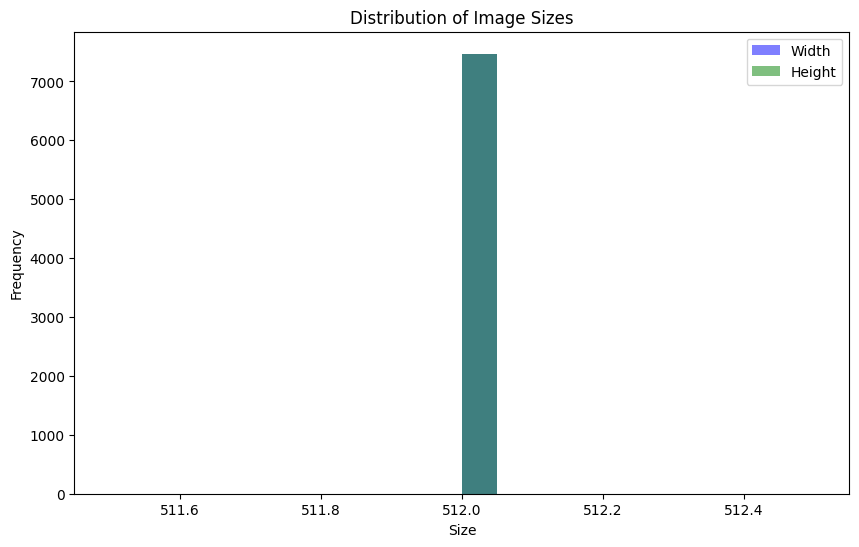

In [31]:


# Define the folder path where the images are located
folder_path = 'NLMCXR_png_resized/'

# Get the list of image files in the folder
image_files = [file for file in os.listdir(folder_path) if file.endswith('.jpg') or file.endswith('.png')]

# Initialize lists to store the image sizes
widths = []
heights = []

# Iterate through the image files and get their sizes
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    image = cv2.imread(image_path)
    height, width, _ = image.shape
    widths.append(width)
    heights.append(height)

# Plot the distribution of image sizes
plt.figure(figsize=(10, 6))
plt.hist(widths, bins=20, alpha=0.5, color='blue', label='Width')
plt.hist(heights, bins=20, alpha=0.5, color='green', label='Height')
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.title('Distribution of Image Sizes')
plt.legend()
plt.show()


In [32]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from sklearn.cluster import KMeans

In [34]:
# Function to extract features from images using VGG16
def extract_features(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = model.predict(img_array)
    return features.flatten()

In [35]:
# Function to load images from a directory
def load_images_from_directory(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(directory, filename)
            images.append(img_path)
    return images

In [38]:
# Path to your dataset (lateral and frontal views mixed)
dataset_path = "NLMCXR_png_resized/"

# Load VGG16 model (pre-trained on ImageNet)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(None, None, 3))

# Optional: Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Get image paths
image_paths = load_images_from_directory(dataset_path)

In [39]:
# Extract features from images
features = []
for img_path in image_paths:
    img_features = extract_features(img_path, base_model)
    features.append(img_features)

features = np.array(features)

1/1 [==============================] - 0s 108ms/step


In [40]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(features)


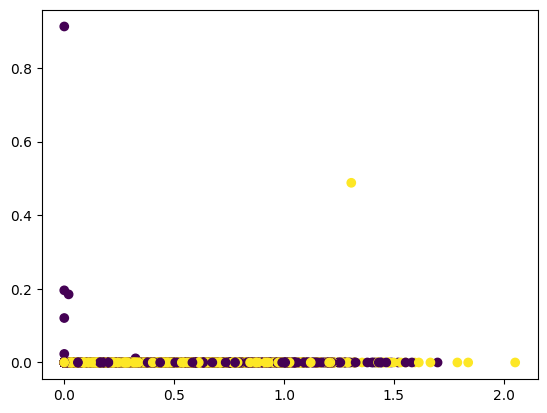

In [41]:
# Visualize clusters (for original features)
plt.scatter(features[:, 0], features[:, 1], c=clusters, cmap='viridis')
plt.show()

In [49]:
# Create a dictionary to store image names and their predicted nature
image_predictions = {}

# Populate the dictionary with image names and cluster labels
for img_path, cluster_label in zip(image_paths, clusters):
    img_name = os.path.basename(img_path)
    if cluster_label == 0:
        image_predictions[img_name] = "frontal"
    else:
        image_predictions[img_name] = "lateral"



In [50]:
len(image_predictions)

7470

In [51]:
import pandas as pd

# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(image_predictions, orient='index', columns=['label'])

# Reset the index and rename the column
df.reset_index(inplace=True)
df.columns = ['Image_name', 'label']

# Save the DataFrame as a CSV file
df.to_csv('image_predictions.csv', index=False)


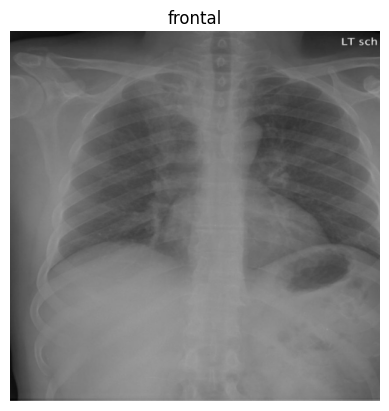

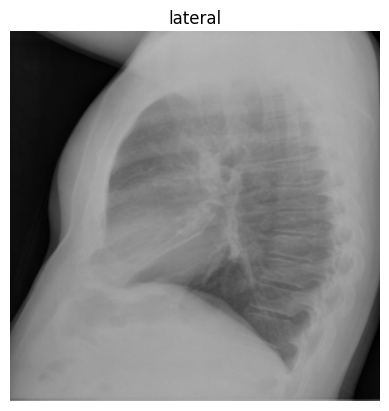

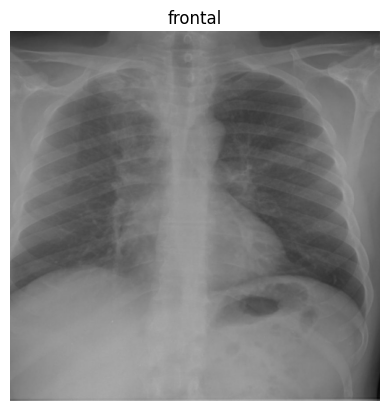

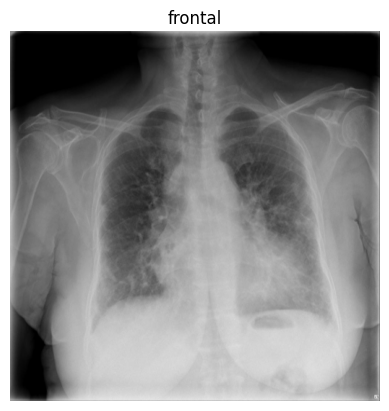

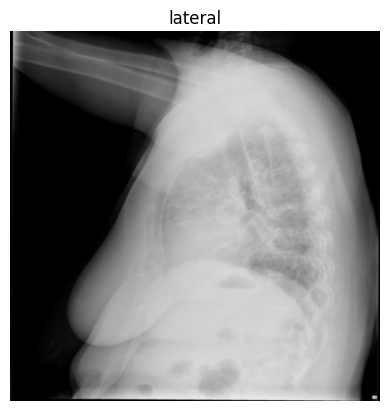

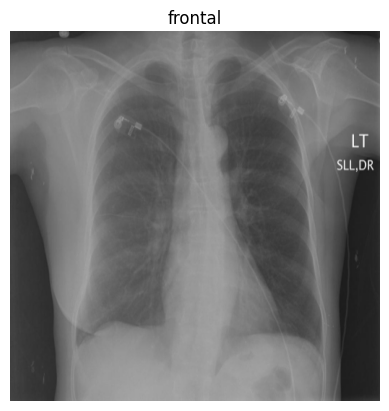

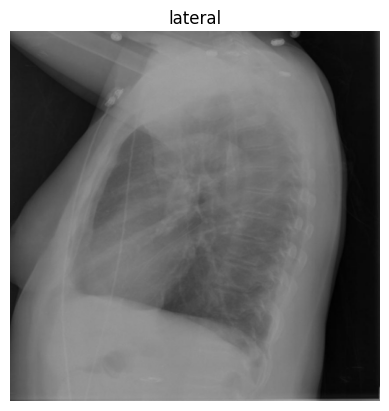

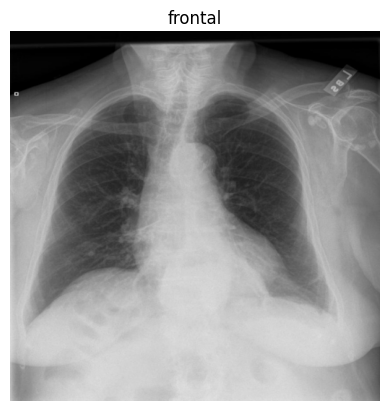

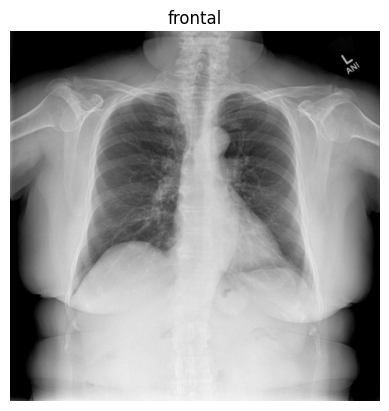

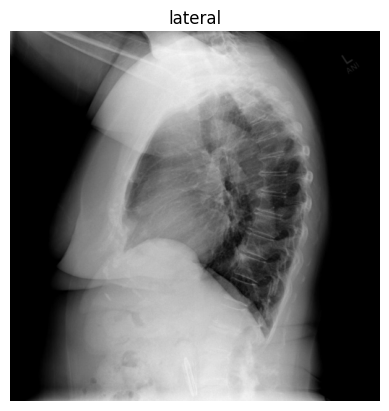

In [53]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Get the first 10 rows from the dataframe
df_subset = df.head(10)

# Iterate through the rows and display the images
for index, row in df_subset.iterrows():
    image_path = os.path.join(folder_path, row['Image_name'])
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.title(row['label'])
    plt.axis('off')
    plt.show()